#### In this notebook, I have used Air Passengers dataset which consists of month of the year and number of passengers from 1949 to 1960 year. Analysed the dataset for trend, seasonality, noise using various statistical functions. Applied SARIMA model to the dataset because dataset has seasonal component. Finally our model forecasts number of passengers expected to travel for next 800 years.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas import concat
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from math import sqrt
from pandas import DataFrame
from pandas import Grouper
from multiprocessing import cpu_count
from joblib import Parallel, delayed
import warnings
from warnings import catch_warnings, filterwarnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas import datetime
import itertools
plt.rcParams["figure.figsize"] = [9,7]

c:\users\mahesh kumar m r\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [2]:
air_pass = pd.read_csv('AirPassengers.csv')

In [3]:
air_pass.head()

,Month,AirPassengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
air_pass.dtypes

Month            object
AirPassengers     int64
dtype: object

In [5]:
air_pass['Month'] = pd.DatetimeIndex(air_pass['Month'])
air_pass.dtypes

Month            datetime64[ns]
AirPassengers             int64
dtype: object

In [6]:
air_pass.set_index('Month', inplace=True)

In [7]:
air_pass.isnull().sum()

AirPassengers    0
dtype: int64

In [8]:
air_pass.describe()

,AirPassengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [9]:
air_pass.shape

(144, 1)

In [10]:
air_pass.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   AirPassengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


### 2. Lag Features

#### Last 1 observed value(lag value) to predcit the value at the next time step. This is the format of dataset expected by any machine learning algorithms.

In [78]:
data_onelag = concat([air_pass.shift(1), air_pass], axis=1)
data_onelag.columns = ['t-1', 't+1']
data_onelag.head(10)

,t-1,t+1
Month,,
1949-01-01,NaN,112
1949-02-01,112.0,118
1949-03-01,118.0,132
1949-04-01,132.0,129
1949-05-01,129.0,121
1949-06-01,121.0,135
1949-07-01,135.0,148
1949-08-01,148.0,148
1949-09-01,148.0,136


#### Last 3 observed values(lag values) to predcit the value at the next time step. This is the format of dataset expected by any machine learning algorithms. [(t-3), (t-2), (t-1)] is an input and t+1 in an output.

In [12]:
data_three_lag = concat([air_pass.shift(3), air_pass.shift(2), air_pass.shift(1), air_pass], axis = 1)
data_three_lag.columns = ['t-3', 't-2', 't-1', 't+1']
data_three_lag.head(10)

,t-3,t-2,t-1,t+1
Month,,,,
1949-01-01,NaN,NaN,NaN,112
1949-02-01,NaN,NaN,112.0,118
1949-03-01,NaN,112.0,118.0,132
1949-04-01,112.0,118.0,132.0,129
1949-05-01,118.0,132.0,129.0,121
1949-06-01,132.0,129.0,121.0,135
1949-07-01,129.0,121.0,135.0,148
1949-08-01,121.0,135.0,148.0,148
1949-09-01,135.0,148.0,148.0,136


#### Rolling Window - instead of just adding the raw lagged values is to add a summary (mean, sum, etc) across the values in the window at previous time steps.

In [13]:
shifted = air_pass.shift(1)
window_mean = shifted.rolling(window = 2).mean()
data_window_mean = concat([window_mean, air_pass], axis=1)
data_window_mean.columns = ['mean(t-2, t-1)', 't+1']
data_window_mean.head(10)

,"mean(t-2, t-1)",t+1
Month,,
1949-01-01,NaN,112
1949-02-01,NaN,118
1949-03-01,115.0,132
1949-04-01,125.0,129
1949-05-01,130.5,121
1949-06-01,125.0,135
1949-07-01,128.0,148
1949-08-01,141.5,148
1949-09-01,148.0,136


#### Below is another example that shows a window width of 3 and a dataset comprised of more summary statistics, specifically the minimum, mean, and maximum value in the window.

In [14]:
width = 3
shifted = air_pass.shift(width-1)
window = shifted.rolling(window = width)
data_window_3 = concat([window.min(), window.mean(), window.max(), air_pass], axis=1)
data_window_3.columns = ['min', 'mean', 'max', 't+1']
data_window_3.head(10)

,min,mean,max,t+1
Month,,,,
1949-01-01,NaN,NaN,NaN,112
1949-02-01,NaN,NaN,NaN,118
1949-03-01,NaN,NaN,NaN,132
1949-04-01,NaN,NaN,NaN,129
1949-05-01,112.0,120.666667,132.0,121
1949-06-01,118.0,126.333333,132.0,135
1949-07-01,121.0,127.333333,132.0,148
1949-08-01,121.0,128.333333,135.0,148
1949-09-01,121.0,134.666667,148.0,136


### Expanding window

In [15]:
window = air_pass.expanding()
window_exp = concat([window.min(), window.mean(), window.max(), air_pass.shift(1)], axis=1)
window_exp.columns = ['min', 'mean', 'max', 't+1']
window_exp.head(10)

,min,mean,max,t+1
Month,,,,
1949-01-01,112.0,112.000000,112.0,NaN
1949-02-01,112.0,115.000000,118.0,112.0
1949-03-01,112.0,120.666667,132.0,118.0
1949-04-01,112.0,122.750000,132.0,132.0
1949-05-01,112.0,122.400000,132.0,129.0
1949-06-01,112.0,124.500000,135.0,121.0
1949-07-01,112.0,127.857143,148.0,135.0
1949-08-01,112.0,130.375000,148.0,148.0
1949-09-01,112.0,131.000000,148.0,148.0


### 3. Check whether dataset is stationary or not

#### 3.1

#### The below line plot shows that the given time series has trend and seasonal component

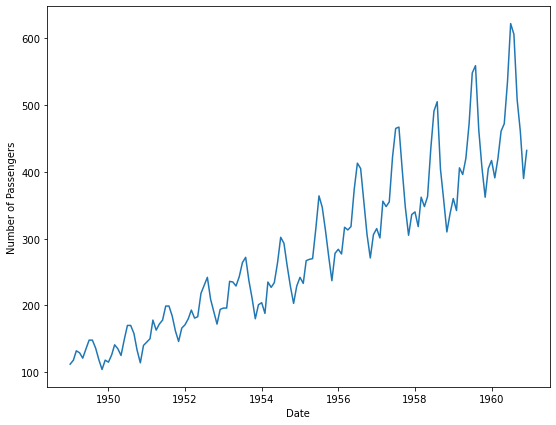

In [16]:
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.plot(air_pass)

#### The below histogram shows that time series data are not uniformly like distribution or gaussian like distribution of values (bell shaped curve). Hence the time series is non-stationary

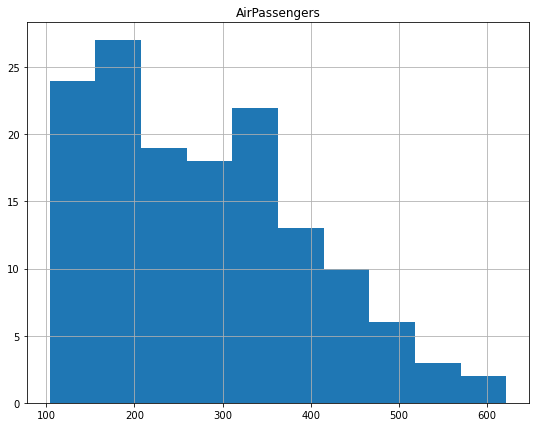

In [17]:
air_pass.hist()
plt.show()

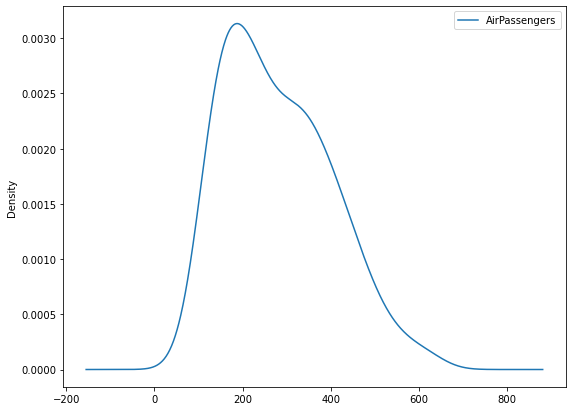

In [18]:
air_pass.plot(kind = 'kde')
plt.show()

#### 3.2 Since the mean and variance of the two groups of dataset vary much, this suggests that the given time series is non- stationary.

In [19]:
def split_data(data):
    split = round(len(air_pass) / 2)
    x1, x2 = air_pass[0:split], air_pass[split:]
    mean1, mean2 = x1.mean(), x2.mean()
    variance1, variance2 = x1.var(), x2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (variance1, variance2))

In [20]:
split_data(air_pass)

mean1=182.902778, mean2=377.694444
variance1=2275.694640, variance2=7471.736307


#### 3.3 Augmented Dickey - Fuller Test
The ADF statistic is positive, meaning we are much less likely to reject the null hypothesis (it looks non-stationary). Comparing the test statistic to the critical values, it looks like we would have to fail to reject the null hypothesis that the time series is non-stationary and does have time-dependent structure. ANother observation is p-value > 0.05, the data is non-stationary

In [21]:
def perform_adf(data):
    result = adfuller(air_pass)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [22]:
perform_adf(air_pass)

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


In [23]:
def check(data):
    moving_average=air_pass.rolling(window=12).mean()
    moving_std=air_pass.rolling(window=12).std()
    plt.plot(air_pass, color = 'green', label = 'Original')
    plt.plot(moving_average, color='red', label = 'Moving Average ')
    plt.plot(moving_std, color='black', label = 'Moving std')
    plt.title('Rolling Mean and Std')
    plt.legend(loc='best')
    plt.show()

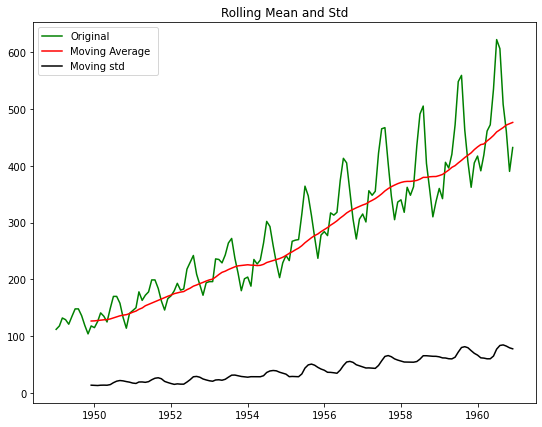

In [24]:
check(air_pass)

### 4. Time Series Decomposition

In [25]:
def decomposition_additive(data):
    results = seasonal_decompose(air_pass, model='additive')
    results.plot()
    plt.show()

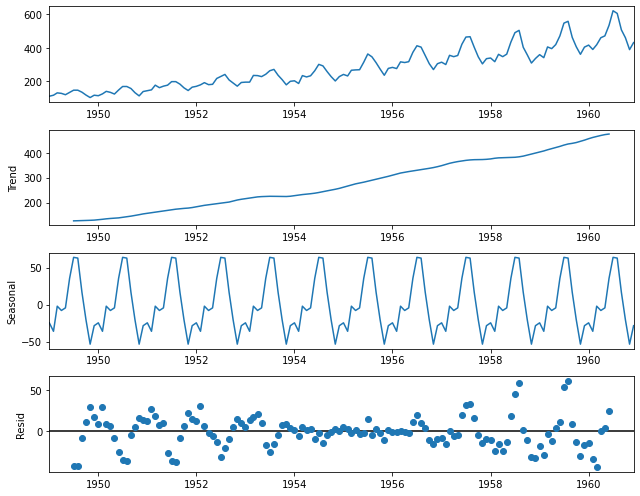

In [26]:
decomposition_additive(air_pass)

In [27]:
def decomposition_multiplicative(data):
    results = seasonal_decompose(air_pass, model='multiplicative')
    results.plot()
    plt.show()

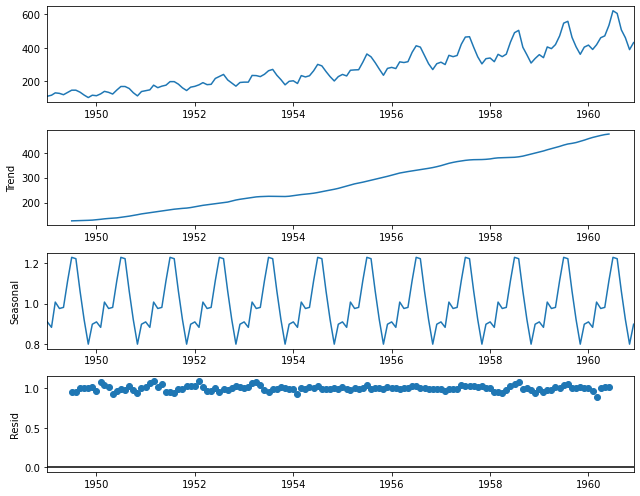

In [28]:
decomposition_multiplicative(air_pass)

#### AutoCorrelation using lag_plot()

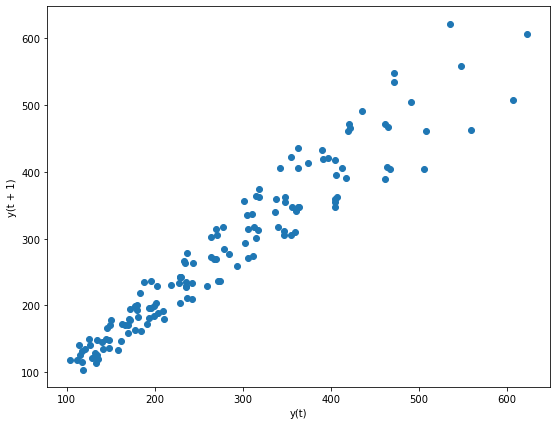

In [29]:
lag_plot(air_pass)
plt.show()

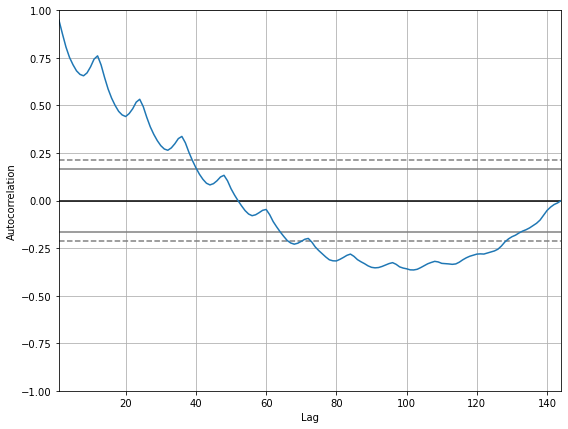

In [30]:
autocorrelation_plot(air_pass)
plt.show()

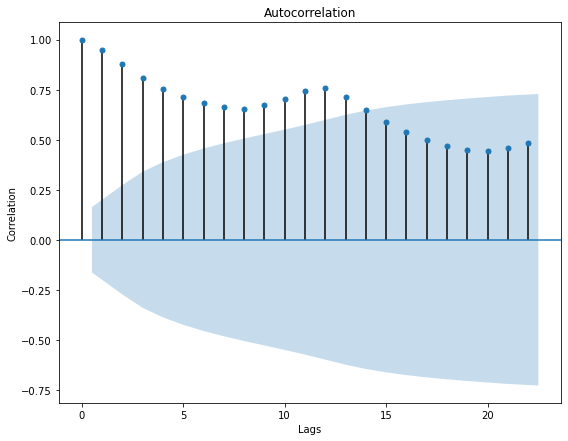

In [31]:
plot_acf(air_pass)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.show()

c:\users\mahesh kumar m r\anaconda3\envs\tensorflow\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


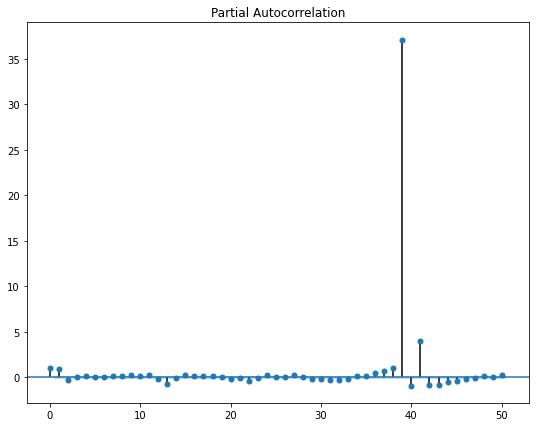

In [32]:
plot_pacf(air_pass, lags=50)
plt.show()

Text(0.5, 1.0, 'first order differencing')

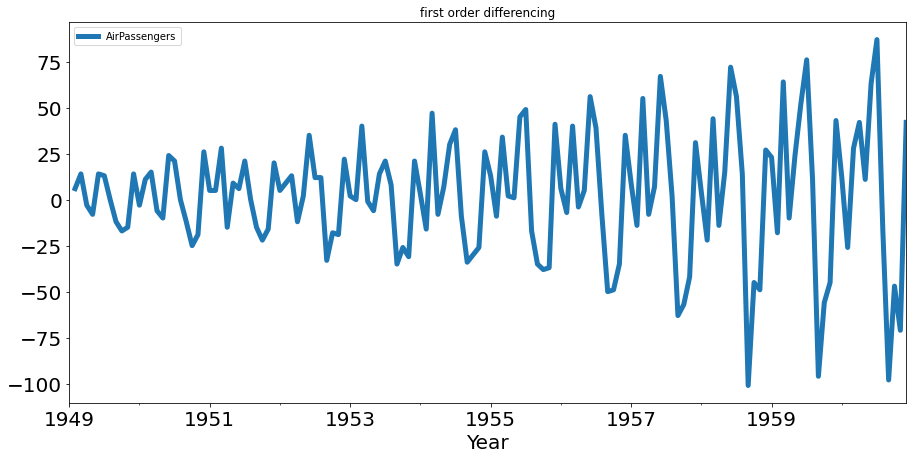

In [53]:
air_pass.diff().plot(figsize=(15,7), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);
plt.title("first order differencing")

Text(0.5, 1.0, 'Second order differencing')

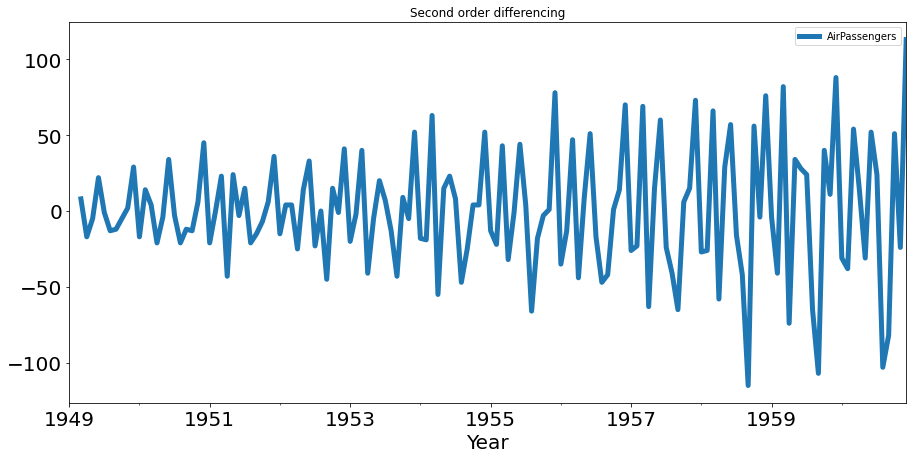

In [57]:
air_pass.diff().diff().plot(figsize=(15,7), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);
plt.title("Second order differencing")

### Seasonal difference

Text(0.5, 1.0, 'Seasonal differencing')

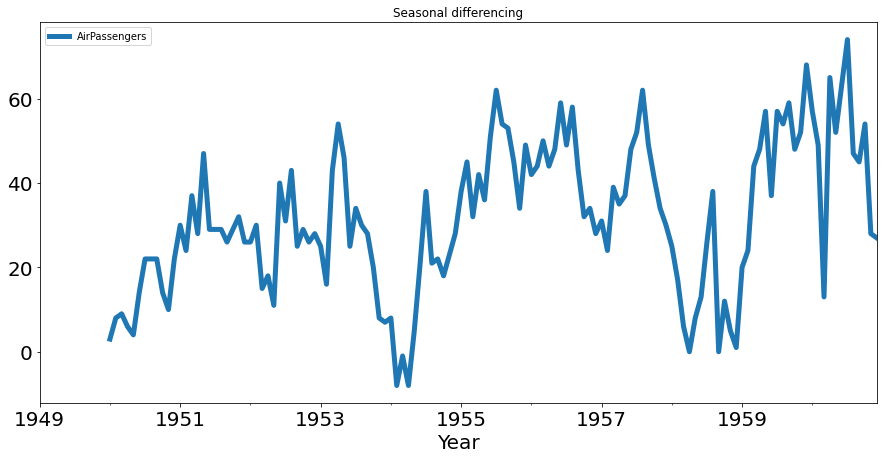

In [58]:
air_pass.diff(12).plot(figsize=(15,7), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);
plt.title("Seasonal differencing")

#### 5. Since the given time series has a seasonal component, use SARIMAX model. Since this model has three parameters for non-seasonal component and four parameters for seasonal component, its better to get the good parameters using grid search.

In [59]:
# Define p, d, q parameters between 0 and 3
p = d = q = range(0,3)
# Generate different combinations of p, d, q
pdq = list(itertools.product(p, d, q))
# Generate different combinations of p, d, q for seasonal component
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [60]:
warnings.filterwarnings("ignore")
for param in pdq:
    for params in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(air_pass, 
                                            order = param,
                                            sesonal_order = params,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            results = mod.fit()
            
            print('ARIMA{}x{} - AIC:{}'.format(param, params, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:2044.4329486427587
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:2044.4329486427587
ARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC:2044.4329486427587
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:2044.4329486427587
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:2044.4329486427587
ARIMA(0, 0, 0)x(0, 1, 2, 12) - AIC:2044.4329486427587
ARIMA(0, 0, 0)x(0, 2, 0, 12) - AIC:2044.4329486427587
ARIMA(0, 0, 0)x(0, 2, 1, 12) - AIC:2044.4329486427587
ARIMA(0, 0, 0)x(0, 2, 2, 12) - AIC:2044.4329486427587
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:2044.4329486427587
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:2044.4329486427587
ARIMA(0, 0, 0)x(1, 0, 2, 12) - AIC:2044.4329486427587
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:2044.4329486427587
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:2044.4329486427587
ARIMA(0, 0, 0)x(1, 1, 2, 12) - AIC:2044.4329486427587
ARIMA(0, 0, 0)x(1, 2, 0, 12) - AIC:2044.4329486427587
ARIMA(0, 0, 0)x(1, 2, 1, 12) - AIC:2044.4329486427587
ARIMA(0, 0, 0)x(1, 2, 2, 12) - AIC:2044.4329486427587
ARIMA(0, 0, 0)x(2, 0, 0, 12)

#### we found from grid search that (2, 1, 2) for non-seasonal and (2, 2, 2, 12) for seasonal component based on AIC metric. lets fit the model with these parameters.

In [61]:
mod = sm.tsa.statespace.SARIMAX(air_pass,
                               order = (2, 1, 2),
                               seasonal_order = (2, 2, 2, 12),
                               enforce_stationarity = False,
                               enforce_invertibility = False)
results = mod.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                      AirPassengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(2, 2, 2, 12)   Log Likelihood                -356.249
Date:                            Sun, 19 Jul 2020   AIC                            730.498
Time:                                    14:45:43   BIC                            753.194
Sample:                                01-01-1949   HQIC                           739.659
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1737      0.277     -4.230      0.000      -1.718      -0.630
ar.L2         -0.2921      0.245   

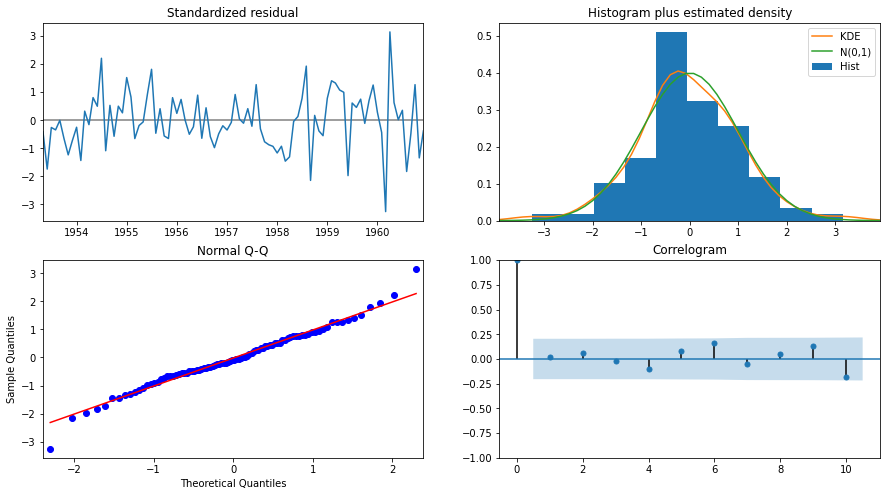

In [62]:
results.plot_diagnostics(figsize = (15, 8))
plt.show()

### 6. Validating forecasts: forecast to start at 1955-01-01, dynamic = False

In [63]:
pred = results.get_prediction(start = pd.to_datetime('1955-01-01'), dynamic = False)
pred_ci = pred.conf_int()

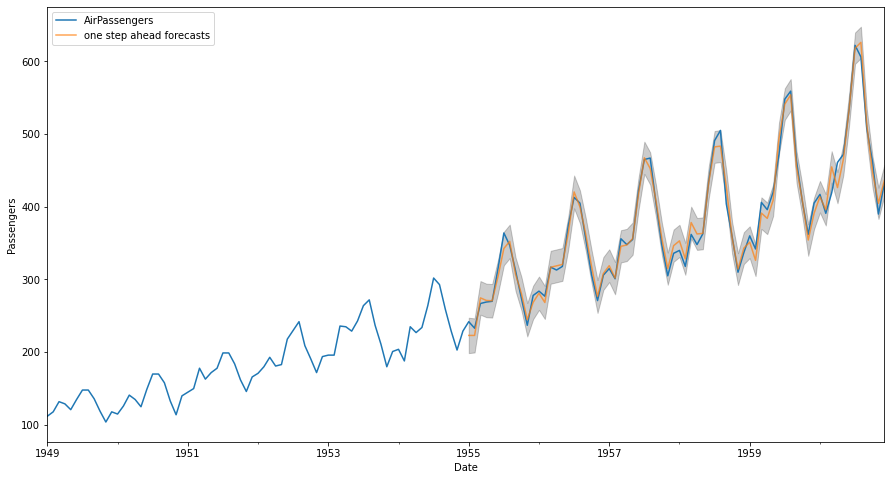

In [64]:
ax = air_pass['1949':].plot(label='observed', figsize = (15, 8))
pred.predicted_mean.plot(ax=ax, label = 'one step ahead forecasts', alpha = .7)

ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1], color = 'k', alpha = .2)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.show()

In [65]:
air_pass_forecast = pred.predicted_mean
air_pass_actual = air_pass['1955-01-01':]
mae = mean_absolute_error(air_pass_actual, air_pass_forecast)
mse = mean_squared_error(air_pass_actual, air_pass_forecast)
rmse = sqrt(mse)
print('Mean Absoulte Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)

Mean Absoulte Error: 8.933241152482019
Mean Squared Error: 132.96942535020304
Root Mean Squared Error: 11.5312369392968


### 7. Validating forecasts: forecast to start at 1955-01-01, dynamic = True

In [66]:
pred_dynamic = results.get_prediction(start = pd.to_datetime('1955-01-01'), dynamic = True, full_results = True)
pred_dynamic_ci = pred_dynamic.conf_int()

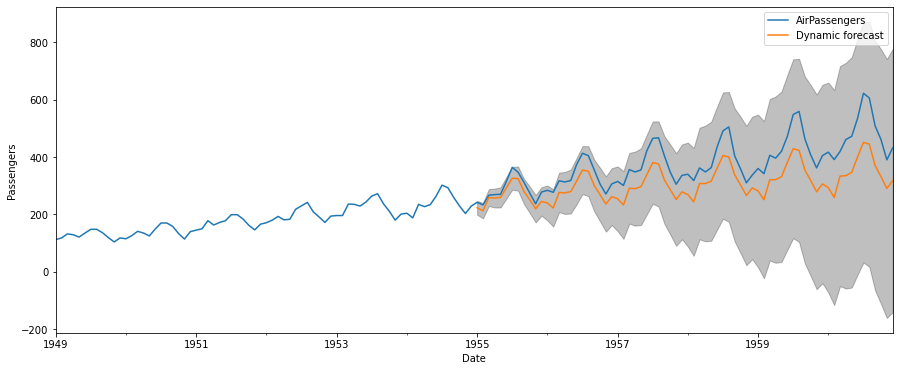

In [67]:
ax1 = air_pass['1949':].plot(label='observed', figsize = (15, 6))
pred_dynamic.predicted_mean.plot(ax=ax1, label = 'Dynamic forecast')

ax1.fill_between(pred_dynamic_ci.index,
               pred_dynamic_ci.iloc[:, 0],
               pred_dynamic_ci.iloc[:, 1], color = 'k', alpha = .25)
ax1.set_xlabel('Date')
ax1.set_ylabel('Passengers')
plt.legend()
plt.show()

In [68]:
air_pass_forecast_dynamic = pred_dynamic.predicted_mean
air_pass_actual = air_pass['1955-01-01':]
mae_dynamic = mean_absolute_error(air_pass_actual, air_pass_forecast_dynamic)
mse_dynamic = mean_squared_error(air_pass_actual, air_pass_forecast_dynamic)
rmse_dynamic = sqrt(mse_dynamic)
print('Mean Absoulte Error:', mae_dynamic)
print('Mean Squared Error:', mse_dynamic)
print('Root Mean Squared Error:', rmse_dynamic)

Mean Absoulte Error: 70.63457691978616
Mean Squared Error: 6395.258911352398
Root Mean Squared Error: 79.97036270614507


### Forecast future values for next 800 years

In [74]:
# Get forecast 800 steps ahead in future
pred_uc = results.get_forecast(steps=800)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

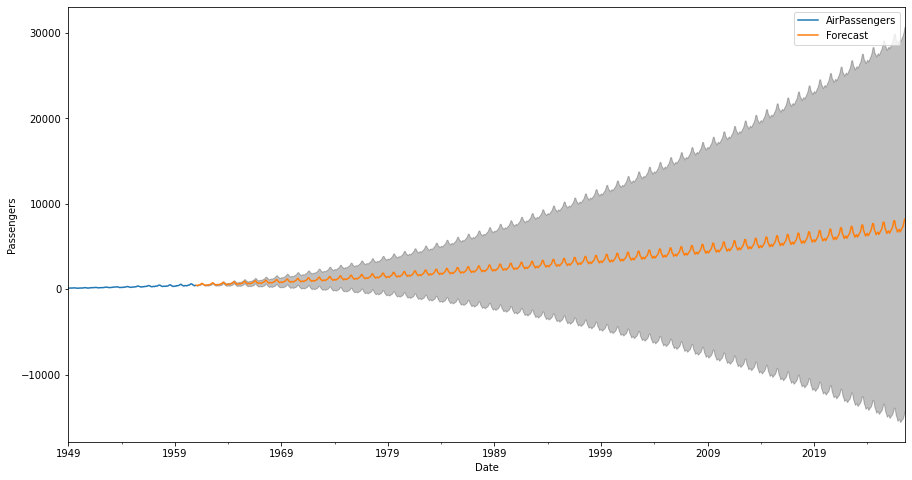

In [75]:
ax3 = air_pass.plot(label='observed', figsize=(15, 8))
pred_uc.predicted_mean.plot(ax=ax3, label='Forecast')
ax3.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax3.set_xlabel('Date')
ax3.set_ylabel('Passengers')

plt.legend()
plt.show()

In [76]:
results.forecast(800)

1961-01-01     452.568926
1961-02-01     420.131687
1961-03-01     466.892168
1961-04-01     489.063795
1961-05-01     510.560720
                 ...     
2027-04-01    7118.749963
2027-05-01    7283.292543
2027-06-01    7669.332072
2027-07-01    8197.318640
2027-08-01    8138.153444
Freq: MS, Length: 800, dtype: float64